In [ ]:
# Carga de librerías necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder



In [110]:
# Cargar el dataset de entrenamiento
train_df = pd.read_csv(r'C:\Users\GIGABYTE\Documents\tareas_bootcamp_coding_dojo\mod_2_machine_learning\8_clasificacion_utilizando_lgbm\data\train.csv')
train_df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [111]:
# Cargar el dataset de entrenamiento
test_df = pd.read_csv(r'C:\Users\GIGABYTE\Documents\tareas_bootcamp_coding_dojo\mod_2_machine_learning\8_clasificacion_utilizando_lgbm\data\test.csv')
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [112]:
# Exploración inicial
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [113]:
# Renombrar columnas del dataset
train_df.columns = (
    train_df.columns
    .str.strip()               # Elimina espacios iniciales y finales
    .str.replace("'", "")      # Elimina comillas simples
    .str.replace("-", "_")     # Reemplaza guiones por guiones bajos
    .str.replace(" ", "_")     # Reemplaza espacios por guiones bajos
    .str.lower()               # Convierte todo a minúsculas
)

# Mostrar nombres de las columnas normalizados
print(train_df.columns)
print()
train_df.info()

Index(['loan_id', 'gender', 'married', 'dependents', 'education',
       'self_employed', 'applicantincome', 'coapplicantincome', 'loanamount',
       'loan_amount_term', 'credit_history', 'property_area', 'loan_status'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_id            614 non-null    object 
 1   gender             601 non-null    object 
 2   married            611 non-null    object 
 3   dependents         599 non-null    object 
 4   education          614 non-null    object 
 5   self_employed      582 non-null    object 
 6   applicantincome    614 non-null    int64  
 7   coapplicantincome  614 non-null    float64
 8   loanamount         592 non-null    float64
 9   loan_amount_term   600 non-null    float64
 10  credit_history     564 non-null    float64
 11  property_area      61

In [114]:
train_df.describe()

,applicantincome,coapplicantincome,loanamount,loan_amount_term,credit_history
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


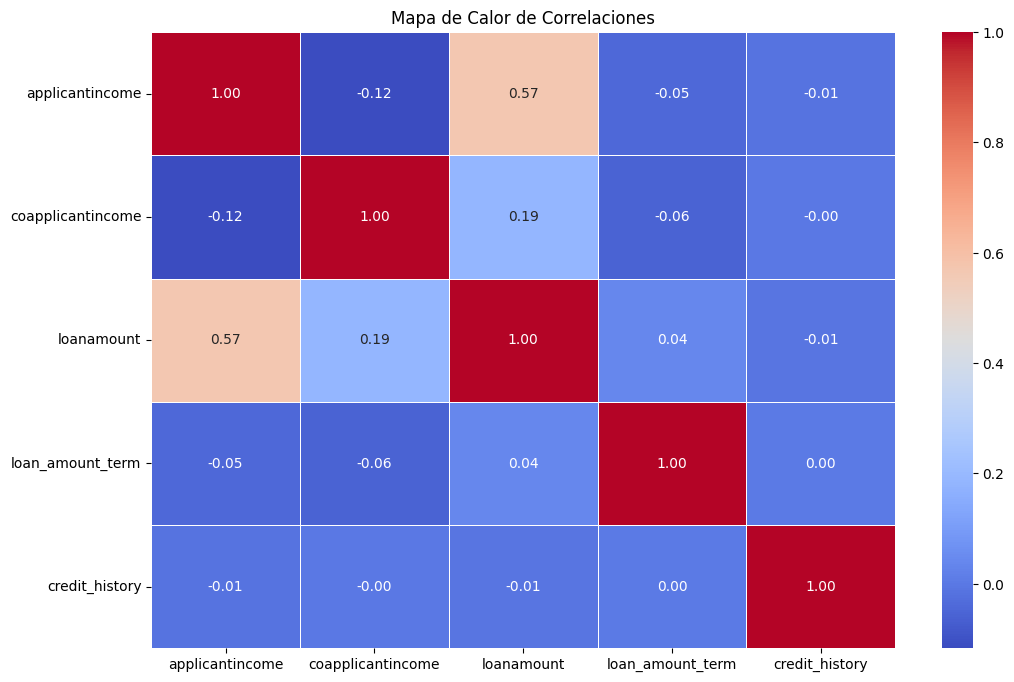

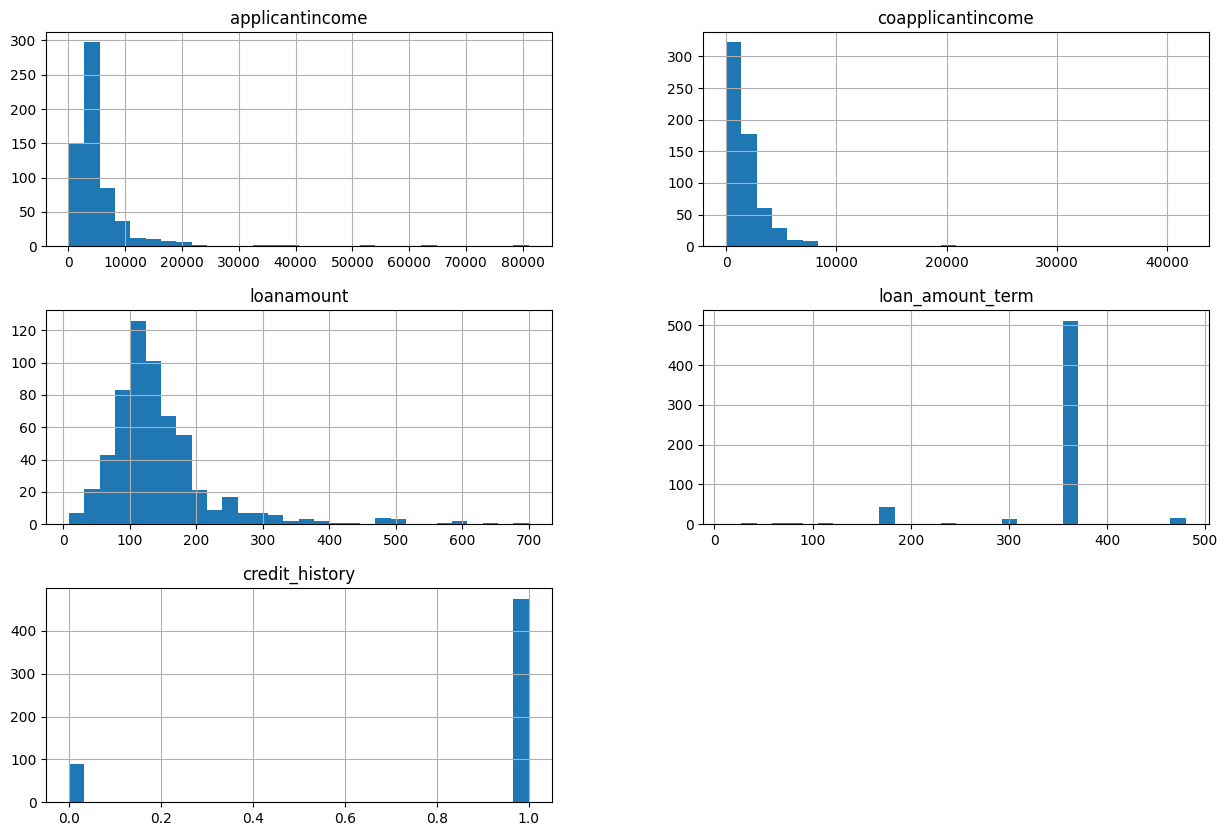

In [115]:
# Mapa de calor de las correlaciones
correlation_matrix = train_df.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

# Visualización de la distribución de las variables
train_df.hist(bins=30, figsize=(15, 10))
plt.show()

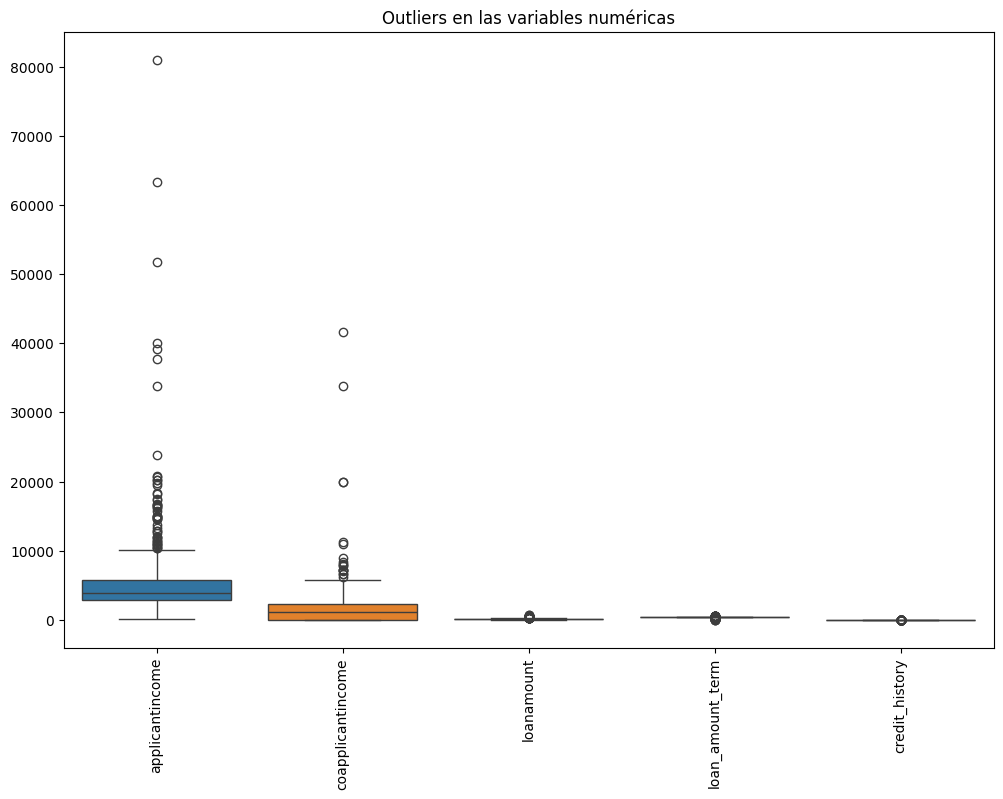

In [116]:
# Visualización de outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=train_df.select_dtypes(include=[np.number]))
plt.title('Outliers en las variables numéricas')
plt.xticks(rotation=90)
plt.show()


In [117]:
# Rellenar valores faltantes en variables categóricas con el valor 'Unknown'
train_df['gender'] = train_df['gender'].fillna('Unknown')
train_df['married'] = train_df['married'].fillna('Unknown')
train_df['dependents'] = train_df['dependents'].fillna('Unknown')
train_df['self_employed'] = train_df['self_employed'].fillna('Unknown')

# Rellenar valores faltantes en variables numéricas con la mediana
train_df['loan_amount_term'] = train_df['loan_amount_term'].fillna(train_df['loan_amount_term'].median())
train_df['loanamount'] = train_df['loanamount'].fillna(train_df['loanamount'].median())
train_df['credit_history'] = train_df['credit_history'].fillna(train_df['credit_history'].median())

# Verificar si hay valores faltantes
print("\nValores faltantes después de tratamiento:")
print(train_df.isnull().sum())




Valores faltantes después de tratamiento:
loan_id              0
gender               0
married              0
dependents           0
education            0
self_employed        0
applicantincome      0
coapplicantincome    0
loanamount           0
loan_amount_term     0
credit_history       0
property_area        0
loan_status          0
dtype: int64


In [118]:
# Codificar variables categóricas con One-Hot Encoding
train_df = pd.get_dummies(train_df, columns=['gender', 'married', 'dependents', 'education', 'self_employed', 'property_area'], drop_first=True)

# Ver los primeros registros después de la codificación
print("\nDatos después de One-Hot Encoding:")
print(train_df.head())



Datos después de One-Hot Encoding:
    loan_id  applicantincome  coapplicantincome  loanamount  loan_amount_term  \
0  LP001002             5849                0.0       128.0             360.0   
1  LP001003             4583             1508.0       128.0             360.0   
2  LP001005             3000                0.0        66.0             360.0   
3  LP001006             2583             2358.0       120.0             360.0   
4  LP001008             6000                0.0       141.0             360.0   

   credit_history loan_status  gender_Male  gender_Unknown  married_Unknown  \
0             1.0           Y         True           False            False   
1             1.0           N         True           False            False   
2             1.0           Y         True           False            False   
3             1.0           Y         True           False            False   
4             1.0           Y         True           False            False   

  

In [119]:

# Dividir el dataset en conjunto de entrenamiento y prueba
X = train_df.drop(columns=['loan_id', 'loan_status'])
y = train_df['loan_status']

# Dividir en datos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nDatos divididos en entrenamiento y prueba:")
print(f"Tamaño de X_train: {X_train.shape}, X_test: {X_test.shape}")



Datos divididos en entrenamiento y prueba:
Tamaño de X_train: (491, 18), X_test: (123, 18)


In [120]:
# Convertir etiquetas de 'Y'/'N' a 1/0
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Convierte 'N'/'Y' a 0/1
y_test = label_encoder.transform(y_test)

# Crear el modelo de LightGBM
lgbm_model = LGBMClassifier()

# Entrenar el modelo
lgbm_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = lgbm_model.predict(X_test)

# Evaluar el modelo
print("\nEvaluación del modelo:")
print(f"Exactitud: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precisión: {precision_score(y_test, y_pred, pos_label=1):.4f}")  # Clase positiva = 1
print(f"Recall: {recall_score(y_test, y_pred, pos_label=1):.4f}")  # Clase positiva = 1
print(f"F1-Score: {f1_score(y_test, y_pred, pos_label=1):.4f}")  # Clase positiva = 1
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")  # Asegura usar las clases transformadas


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [121]:

# Definir los hiperparámetros a probar
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 40, 60]
}

# Realizar GridSearchCV
grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Resultados de la optimización
print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar el modelo optimizado
y_pred_optimized = grid_search.best_estimator_.predict(X_test)

print("\nEvaluación del modelo optimizado:")
print(f"Exactitud: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precisión: {precision_score(y_test, y_pred_optimized, pos_label=1):.4f}")  # Clase positiva = 1
print(f"Recall: {recall_score(y_test, y_pred_optimized, pos_label=1):.4f}")  # Clase positiva = 1
print(f"F1-Score: {f1_score(y_test, y_pred_optimized, pos_label=1):.4f}")  # Clase positiva = 1
print(f"ROC-AUC: {roc_auc_score(y_test, grid_search.best_estimator_.predict_proba(X_test)[:, 1]):.4f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 228, number of negative: 99
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 272
[LightGBM] [Info] Number of data points in the train set: 327, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.697248 -> initscore=0.834226
[LightGBM] [Info] Start training from score 0.834226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 